In [21]:
import csv
import glob
import requests
from datetime import date
import pandas as pd
from bs4 import BeautifulSoup
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.service import Service
import matplotlib.pyplot as plt

In [2]:
def get_html_code(job_name, page_number):
    url = f'https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27{job_name.split()[0]}%20{job_name.split()[1]}%27&page={page_number}'
    service = Service('./chromedriver.exe')
    browser = Chrome(service = service)
    browser.get(url)
    res = browser.page_source
    browser.quit()
    return res

In [3]:
def announcements(page_code):
    soup = BeautifulSoup(page_code, 'html.parser')
    try:
        res = soup.select('.d-flex.justify-content-center.flex-column h2')[0].text.strip()
        if res == 'Nie znaleziono ofert.':
            return False
    except Exception:
        return True

In [4]:
def save_html_code(job_name):
    res = requests.get(f'https://nofluffjobs.com/pl/?criteria=jobPosition%3D%27{job_name.split()[0]}%20{job_name.split()[1]}%27&page=1')
    soup = BeautifulSoup(res.text, 'html.parser')
    try:
        number_of_pages = int(soup.select('.page-link')[-2].text.strip())
    except Exception:
        number_of_pages = 1
    for page_number in range(1, number_of_pages + 1):
        page_code = get_html_code(job_name, page_number)
        if announcements(page_code):
            with open(f'./data/raw/{job_name}_{page_number}.html', 'w', encoding = 'UTF-8') as f:
                f.write(page_code)
        else:
            break

In [99]:
save_html_code('data analyst')
save_html_code('data scientist')
save_html_code('data engineer')

In [5]:
def get_announcements_html(page_html):
    announcements_html = []
    htmls = page_html.split('><!----><!----><!----></common-lazy-render><!----><!----><!----><!----></div><!----></a>')
    idx = 1
    for html in htmls[0:-1]:
        if idx == 1:
            html = html.split('id="undefinedJobs"')[1]
            idx = 0
        announcements_html.append(html)
    return announcements_html

In [6]:
def get_data(announcement_html):
    data = {
        'name': '',
        'company': '',
        'technology': '',
        'job': '',
        'location': {'city': '', 'country': ''},
        'salary': {'low': '', 'high': '', 'currency': ''} 
    }

    soup = BeautifulSoup(announcement_html, 'html.parser')
        
    try:       
        data['name'] = soup.select('.align-items-lg-center h3')[0].text.strip()
    except Exception:
        pass
    try:
        data['company'] = soup.select('.align-items-lg-center span')[0].text.strip()
    except Exception:
        pass
    try:
        if len(soup.select('.ng-star-inserted a')[0].text.strip().split(' ')) > 2:
            pass
        else:
            data['technology'] = soup.select('.ng-star-inserted a')[0].text.strip()
    except Exception:
        pass
    try:
        data['location']['city'] = soup.select('.font-size-14.posting-info__location.d-flex.align-items-center.ml-auto.mr-1.flex-shrink-0')[0].text.split(',')[0].strip().split(' ')[0]
    except Exception:
        pass
    try:
        data['location']['country'] = soup.select('.font-size-14.posting-info__location.d-flex.align-items-center.ml-auto.mr-1.flex-shrink-0')[0].text.split(',')[1].strip().split(' ')[0]
    except Exception:
        pass    
    try:
        if len(soup.select('.text-truncate.badgy.salary.btn.btn-outline-secondary.btn-sm.font-size-12.ng-star-inserted')[0].text.split('–')[0].strip()) > 8:
            data['salary']['low'] = int(soup.select('.text-truncate.badgy.salary.btn.btn-outline-secondary.btn-sm.font-size-12.ng-star-inserted')[0].text.split('–')[0].strip().split()[0] + soup.select('.text-truncate.badgy.salary.btn.btn-outline-secondary.btn-sm.font-size-12.ng-star-inserted')[0].text.split('–')[0].strip().split()[1])
            data['salary']['high'] = data['salary']['low']
            data['salary']['currency'] = soup.select('.text-truncate.badgy.salary.btn.btn-outline-secondary.btn-sm.font-size-12.ng-star-inserted')[0].text.split('–')[0].strip().split()[2]
        else:
            data['salary']['low'] = int(soup.select('.text-truncate.badgy.salary.btn.btn-outline-secondary.btn-sm.font-size-12.ng-star-inserted')[0].text.split('–')[0].strip().split()[0] + soup.select('.text-truncate.badgy.salary.btn.btn-outline-secondary.btn-sm.font-size-12.ng-star-inserted')[0].text.split('–')[0].strip().split()[1])
            data['salary']['high'] = int(soup.select('.text-truncate.badgy.salary.btn.btn-outline-secondary.btn-sm.font-size-12.ng-star-inserted')[0].text.split('–')[1].strip().split('  ')[0].strip().split()[0] + soup.select('.text-truncate.badgy.salary.btn.btn-outline-secondary.btn-sm.font-size-12.ng-star-inserted')[0].text.split('–')[1].strip().split('  ')[0].strip().split()[1])
            data['salary']['currency'] = soup.select('.text-truncate.badgy.salary.btn.btn-outline-secondary.btn-sm.font-size-12.ng-star-inserted')[0].text.split('–')[1].strip().split('  ')[1]
    except Exception:
        pass
    
    return data

In [7]:
res = []
files = glob.glob('./data/raw/*.html')
for file in files:
    with open(file, 'r', encoding = 'UTF-8') as f:
        content = f.read()
    htmls = get_announcements_html(content)
    for html in htmls:
        data = get_data(html)
        data['job'] = file.split('_')[0].split('\\')[1]
        res.append(data)

In [8]:
with open(f"./data/interim/job_offers_{date.today().strftime('%d-%m-%Y')}.csv", 'w', encoding = 'UTF-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Name', 'Company', 'Technology', 'Job', 'City', 'Country', 'Low Salary', 'High Salary', 'Currency'])
    for data in res:
        writer.writerow([data['name'], data['company'], data['technology'], data['job'], data['location']['city'], data['location']['country'],  data['salary']['low'], data['salary']['high'], data['salary']['currency']])

In [9]:
df = pd.read_csv(f"./data/interim/job_offers_{date.today().strftime('%d-%m-%Y')}.csv", encoding = 'UTF-8')
pd.set_option('display.max_rows', None)
df

,Name,Company,Technology,Job,City,Country,Low Salary,High Salary,Currency
0,Junior Account Payable Specialist,NOWA,NaN,data analyst,Zdalnie,NaN,6000,7000,PLN
1,Senior Data Analyst,NOWA,NaN,data analyst,Warszawa,POL,15000,17000,PLN
2,Remote Senior Data Analyst,Justpoint.com,Big query,data analyst,Zdalnie,NaN,12781,19882,PLN
3,Data Manager,RUBIX APPLICATION CENTRE sp. z o.o.,NaN,data analyst,Zdalnie,NaN,7000,12000,PLN
4,Internship in IT - Data Analyst,Grid Dynamics,NaN,data analyst,Wrocław,POL,3500,3500,PLN
5,Data Analyst,WOO Network,SQL,data analyst,Warsaw,POL,23670,35505,PLN
6,Senior Data Scientist,Sunscrapers,Python,data analyst,Zdalnie,NaN,28000,35000,PLN
7,Data Analyst,Devire Sp. z o.o.,NaN,data analyst,Warsaw,POL,10000,18000,PLN
8,UX Researcher,NOVOMATIC Technologies Poland,NaN,data analyst,Zdalnie,NaN,9000,16000,PLN
9,SAP Data Analyst (m/f),Michael Page,NaN,data analyst,Warszawa,POL,10000,20000,PLN


In [10]:
df['Currency'].unique()

array(['PLN'], dtype=object)

In [11]:
df['Name'] = df['Name'].apply(lambda x: x.lower())
df['City'] = df['City'].apply(lambda x: x.lower())
df

,Name,Company,Technology,Job,City,Country,Low Salary,High Salary,Currency
0,junior account payable specialist,NOWA,NaN,data analyst,zdalnie,NaN,6000,7000,PLN
1,senior data analyst,NOWA,NaN,data analyst,warszawa,POL,15000,17000,PLN
2,remote senior data analyst,Justpoint.com,Big query,data analyst,zdalnie,NaN,12781,19882,PLN
3,data manager,RUBIX APPLICATION CENTRE sp. z o.o.,NaN,data analyst,zdalnie,NaN,7000,12000,PLN
4,internship in it - data analyst,Grid Dynamics,NaN,data analyst,wrocław,POL,3500,3500,PLN
5,data analyst,WOO Network,SQL,data analyst,warsaw,POL,23670,35505,PLN
6,senior data scientist,Sunscrapers,Python,data analyst,zdalnie,NaN,28000,35000,PLN
7,data analyst,Devire Sp. z o.o.,NaN,data analyst,warsaw,POL,10000,18000,PLN
8,ux researcher,NOVOMATIC Technologies Poland,NaN,data analyst,zdalnie,NaN,9000,16000,PLN
9,sap data analyst (m/f),Michael Page,NaN,data analyst,warszawa,POL,10000,20000,PLN


In [12]:
df['salary_avg'] = (df['Low Salary'] + df['High Salary']) / 2
df

,Name,Company,Technology,Job,City,Country,Low Salary,High Salary,Currency,salary_avg
0,junior account payable specialist,NOWA,NaN,data analyst,zdalnie,NaN,6000,7000,PLN,6500.0
1,senior data analyst,NOWA,NaN,data analyst,warszawa,POL,15000,17000,PLN,16000.0
2,remote senior data analyst,Justpoint.com,Big query,data analyst,zdalnie,NaN,12781,19882,PLN,16331.5
3,data manager,RUBIX APPLICATION CENTRE sp. z o.o.,NaN,data analyst,zdalnie,NaN,7000,12000,PLN,9500.0
4,internship in it - data analyst,Grid Dynamics,NaN,data analyst,wrocław,POL,3500,3500,PLN,3500.0
5,data analyst,WOO Network,SQL,data analyst,warsaw,POL,23670,35505,PLN,29587.5
6,senior data scientist,Sunscrapers,Python,data analyst,zdalnie,NaN,28000,35000,PLN,31500.0
7,data analyst,Devire Sp. z o.o.,NaN,data analyst,warsaw,POL,10000,18000,PLN,14000.0
8,ux researcher,NOVOMATIC Technologies Poland,NaN,data analyst,zdalnie,NaN,9000,16000,PLN,12500.0
9,sap data analyst (m/f),Michael Page,NaN,data analyst,warszawa,POL,10000,20000,PLN,15000.0


In [13]:
df['City'].unique()
df.loc[df['City'] == 'warsaw', 'City'] = 'warszawa'
df

,Name,Company,Technology,Job,City,Country,Low Salary,High Salary,Currency,salary_avg
0,junior account payable specialist,NOWA,NaN,data analyst,zdalnie,NaN,6000,7000,PLN,6500.0
1,senior data analyst,NOWA,NaN,data analyst,warszawa,POL,15000,17000,PLN,16000.0
2,remote senior data analyst,Justpoint.com,Big query,data analyst,zdalnie,NaN,12781,19882,PLN,16331.5
3,data manager,RUBIX APPLICATION CENTRE sp. z o.o.,NaN,data analyst,zdalnie,NaN,7000,12000,PLN,9500.0
4,internship in it - data analyst,Grid Dynamics,NaN,data analyst,wrocław,POL,3500,3500,PLN,3500.0
5,data analyst,WOO Network,SQL,data analyst,warszawa,POL,23670,35505,PLN,29587.5
6,senior data scientist,Sunscrapers,Python,data analyst,zdalnie,NaN,28000,35000,PLN,31500.0
7,data analyst,Devire Sp. z o.o.,NaN,data analyst,warszawa,POL,10000,18000,PLN,14000.0
8,ux researcher,NOVOMATIC Technologies Poland,NaN,data analyst,zdalnie,NaN,9000,16000,PLN,12500.0
9,sap data analyst (m/f),Michael Page,NaN,data analyst,warszawa,POL,10000,20000,PLN,15000.0


In [14]:
for el in df['Name']:
    if 'senior' in el:
        df.loc[df['Name'] == el, 'is_senior'] = 1
    else:
        df.loc[df['Name'] == el, 'is_senior'] = 0
df

,Name,Company,Technology,Job,City,Country,Low Salary,High Salary,Currency,salary_avg,is_senior
0,junior account payable specialist,NOWA,NaN,data analyst,zdalnie,NaN,6000,7000,PLN,6500.0,0.0
1,senior data analyst,NOWA,NaN,data analyst,warszawa,POL,15000,17000,PLN,16000.0,1.0
2,remote senior data analyst,Justpoint.com,Big query,data analyst,zdalnie,NaN,12781,19882,PLN,16331.5,1.0
3,data manager,RUBIX APPLICATION CENTRE sp. z o.o.,NaN,data analyst,zdalnie,NaN,7000,12000,PLN,9500.0,0.0
4,internship in it - data analyst,Grid Dynamics,NaN,data analyst,wrocław,POL,3500,3500,PLN,3500.0,0.0
5,data analyst,WOO Network,SQL,data analyst,warszawa,POL,23670,35505,PLN,29587.5,0.0
6,senior data scientist,Sunscrapers,Python,data analyst,zdalnie,NaN,28000,35000,PLN,31500.0,1.0
7,data analyst,Devire Sp. z o.o.,NaN,data analyst,warszawa,POL,10000,18000,PLN,14000.0,0.0
8,ux researcher,NOVOMATIC Technologies Poland,NaN,data analyst,zdalnie,NaN,9000,16000,PLN,12500.0,0.0
9,sap data analyst (m/f),Michael Page,NaN,data analyst,warszawa,POL,10000,20000,PLN,15000.0,0.0


In [15]:
df.to_csv(f"./data/processed/job_offers_{date.today().strftime('%d-%m-%Y')}.csv", sep = ';', decimal = '.', index = False, encoding = 'UTF-8')

In [39]:
df_grouped_by_job = df.groupby('Job')
df_grouped_by_job.count()['Name']

Job
data analyst      11
data engineer     70
data scientist    20
Name: Name, dtype: int64

<BarContainer object of 3 artists>

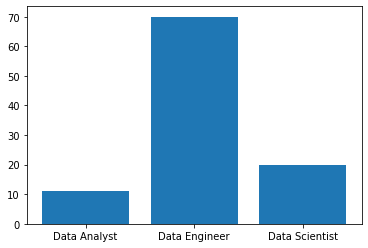

In [41]:
plt.bar(['Data Analyst', 'Data Engineer', 'Data Scientist'], df_grouped_by_job.count()['Name'])

In [42]:
df_grouped_by_job['salary_avg'].mean()

Job
data analyst      15083.545455
data engineer     22741.835714
data scientist    25810.250000
Name: salary_avg, dtype: float64

<BarContainer object of 3 artists>

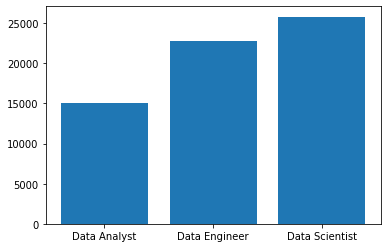

In [43]:
plt.bar(['Data Analyst', 'Data Engineer', 'Data Scientist'], df_grouped_by_job['salary_avg'].mean())

In [57]:
df_grouped_by_city = df.groupby('City')
df_grouped_by_city['Name'].count().sort_values(ascending = False)[0:3]

City
zdalnie     55
warszawa    23
kraków       6
Name: Name, dtype: int64

<BarContainer object of 3 artists>

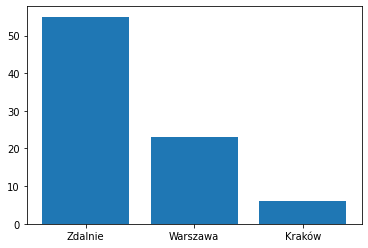

In [58]:
plt.bar(['Zdalnie', 'Warszawa', 'Kraków'], df_grouped_by_city['Name'].count().sort_values(ascending = False)[0:3])

In [59]:
df.loc[df['High Salary'] == df['High Salary'].max()]

,Name,Company,Technology,Job,City,Country,Low Salary,High Salary,Currency,salary_avg,is_senior
81,senior quantitative developer,NOWA,NaN,data scientist,warszawa,POL,40000,50000,PLN,45000.0,1.0


In [60]:
df_grouped_by_position = df.groupby('is_senior')
round(df_grouped_by_position['salary_avg'].mean()[1] - df_grouped_by_position['salary_avg'].mean()[0], 0)

6934.0

In [61]:
df_grouped_by_job['Low Salary'].min()[0] + df_grouped_by_job['Low Salary'].min()[1] + df_grouped_by_job['Low Salary'].min()[2]

14500

In [62]:
df_multigrouped = df.groupby(['City', 'Job'])
df_multigrouped['Low Salary'].min()

City      Job           
budapest  data engineer     11457
chmielów  data engineer     10000
          data scientist    10000
katowice  data engineer     18600
          data scientist     7000
kraków    data engineer     10833
          data scientist    16000
poznań    data engineer     12300
          data scientist    16800
warszawa  data analyst       8000
          data engineer      4000
          data scientist    30771
wrocław   data analyst       3500
          data engineer     12000
          data scientist    16000
zdalnie   data analyst       6000
          data engineer      6000
          data scientist    14000
Name: Low Salary, dtype: int64

In [63]:
df_multigrouped = df.loc[(df['City'] == 'warszawa') | (df['City'] == 'wrocław')].groupby(['City', 'Job'])
WAW = df_multigrouped['Low Salary'].min()[0] + df_multigrouped['Low Salary'].min()[1] + df_multigrouped['Low Salary'].min()[2]
WRO = df_multigrouped['Low Salary'].min()[3] + df_multigrouped['Low Salary'].min()[4] + df_multigrouped['Low Salary'].min()[5]
print(f"WAW = {WAW}")
print(f"WRO = {WRO}")

WAW = 42771
WRO = 31500
